In [4]:
import pandas as pd
import numpy as np
import xarray as xr
import seaborn as sns
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [6]:
amoc=pd.read_csv('amoc_control.txt')
#sst_annual = xr.open_dataset('tas_annual.nc')
#st_annual = xr.open_dataset('ts_annual.nc')

In [ ]:
sst_annual.time

In [ ]:
#polar coordinates carry less spatial weight than other coordinates, now this matches cdo
weights = np.cos(np.deg2rad(sst_annual.lat))
tas_mean = sst_annual.tas.weighted(weights).mean(("lat","lon"))
print(tas_mean)
plt.figure()
sns.set_palette(['#7abe80'])
sns.set_style("darkgrid")
#global_mean.plot()
tas_mean.plot()

In [ ]:
#global mean
global_mean = sst_annual.tas.mean(['lat','lon'])
st_mean = st_annual.ts.mean(['lat','lon'])
#change to years instead of time intervals
#global_mean['Year'] = list(range(0,999))
#st_mean['Year'] = list(range(0,999))
plt.figure()
sns.set_palette(['#7abe80'])
sns.set_style("darkgrid")
#global_mean.plot()
st_mean.plot()


'''
sns.lineplot(data=global_mean,x="Year",y="tas")
plt.ylabel("Average temp 2M below")
plt.title("Annual Average Temperatures 2M Below Sea Surface over 1000 Years")
global_mean.head()
#plt.show()
plt.savefig("lineplot_tas.png")

plt.figure()
plt.hist(global_mean["tas"])
plt.title("Distribution of Temperatures 2m Below Sea Surface")
plt.xlabel("Average temp 2M below")
#plt.show()
plt.savefig("histplot_tas.png")
'''

In [ ]:
print(sst_n['tas'].unique())
print(np.min(sst_n['tas']))
print(sst_n['tas'].mode())
#sst_n.head()

In [ ]:
print(sst_ocean['tas'].unique())
print(np.min(sst_ocean['tas']))
print(sst_ocean['tas'].mode())

In [ ]:
plt.figure()

sns.lineplot(data=st_mean,x="Year",y="ts")
plt.ylabel("Average surface temp")
plt.title("Annual Average Sea Surface Temperature over 1000 Years")
global_mean.head()
#plt.show()
plt.savefig("lineplot_ts.png")

plt.figure()
plt.hist(st_mean["ts"])
plt.title("Distribution of Sea Surface Temperatures")
plt.xlabel("Average surface temp")
#plt.show()
plt.savefig("histplot_ts.png")

In [ ]:

n_years = 1000
months_per_year = 12
# Year column: 1001 to 2000, repeated 12 times each
amoc['Year'] = np.repeat(np.arange(1001, 2001), months_per_year)

# Month column: 1 to 12 repeated for each year
amoc['Month'] = np.tile(np.arange(1, 13), n_years)
amoc.head()

In [ ]:
#average for years
annual_average = amoc.groupby('Year')['AMOC index'].mean()
annual_average.head()
amocs = annual_average.to_frame()

In [ ]:
plt.figure()
sns.lineplot(data=amocs,x="Year",y="AMOC index")
plt.title("AMOC Index for 1000 years")
plt.savefig("f_controlrun_timeseries.png")

In [ ]:
#find mean and standard deviation for Amoc index

#put amoc values in arrays for handling
amoc_list = amocs['AMOC index'].tolist()
print(len(amoc_list))
#find mean and standard deviation
control_mean = np.mean(amoc_list)
control_std_dev = np.std(amoc_list)
control_variance = np.var(amoc_list)
print('mean: ',control_mean,'standard deviation: ',control_std_dev,'variance: ',control_variance)

In [ ]:
plt.hist(amoc_list)
plt.title('Probability Distribution of AMOC values in Control Run')
plt.savefig('control_hist.png')

In [19]:
amoc_list = amoc.values.flatten()
num_slices = 10
slice_length = len(amoc_list) // num_slices

#Split series into slices
slices = np.array_split(amoc_list, num_slices)

#Initialize array to store ACF for each slice
expectations = np.zeros((num_slices, slice_length))

for slice_num, s in enumerate(slices):
    s = np.array(s)
    mean_s = np.mean(s)
    var_s = np.var(s)

    #Compute autocovariance for each lag
    for lag in range(slice_length):
        #Take all overlapping pairs at this lag, s[:len(s)-lag] -> all except last values, (s[lag:]) -> all except first vals
        products = (s[:len(s)-lag] - mean_s) * (s[lag:] - mean_s)
        expectations[slice_num, lag] = np.mean(products) / var_s 

#Average ACF across slices
ACF = np.mean(expectations, axis=0)

-0.32941942291600146


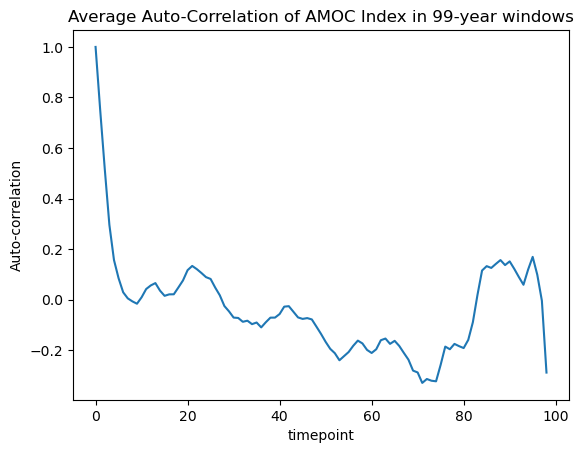

In [20]:
#plot autocorrelation function
print(min(ACF))
plt.figure()
plt.plot(ACF)
plt.title(f"Average Auto-Correlation of AMOC Index in {slice_length}-year windows")
plt.xlabel('timepoint')
plt.ylabel('Auto-correlation')
plt.savefig('acfunc_control_10slice.png')


In [21]:
#integral auto-correlation time (system memory), tau
delta_t = 1
mults=[]
for auto in range(len(ACF[:10])):
    mults.append(ACF[auto]*delta_t)
tau = np.sum(mults)
print(tau)

2.8167739687339792


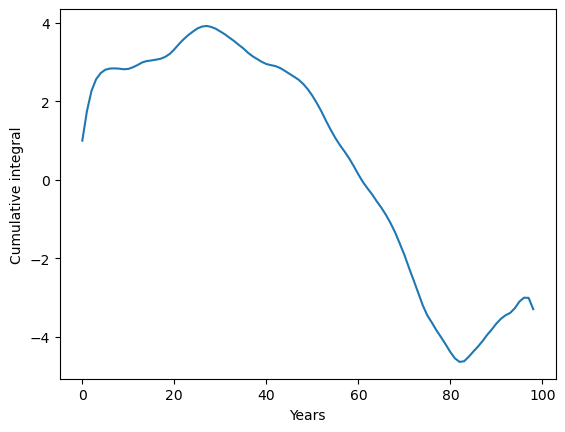

In [22]:
tau_cum = np.cumsum(ACF * delta_t)
lags = np.arange(len(ACF))

plt.plot(lags, tau_cum)
plt.xlabel("Years")
plt.ylabel("Cumulative integral")
plt.savefig("cumulative_integral.png")

In [ ]:
#first 10 years
lags = np.arange(100) 

#exponential decay function
def exp_decay(t, tau):
    return np.exp(-t / tau)

#Fit exp function
popt, _ = curve_fit(exp_decay, lags, ACF)

tau_fit = popt[0]
print("Estimated correlation timescale (years):", tau_fit)

In [27]:
control_variance = np.var(amoc_list)
control_mean=np.mean(amoc_list)
control_std_dev=np.std(amoc_list)
print("Variance:",control_variance,"Mean:",control_mean,"Std dev:",control_std_dev)
#compute k
#print(control_variance)
#a = control_mean - 3*control_std_dev
#imagine we target a specific anomaly, 10 SV, get how many std dev below mean to get that anomaly
z = (10 - control_mean) / control_std_dev
print("Z",z)
#so the anomaly is 13 standard deviations below the mean, just to confirm:
a=control_mean-13*control_std_dev
print("A",a)
#print(control_std_dev)
#print(a)
k=a/(tau*control_variance)
print("K",k)

Variance: 0.5322334931401672 Mean: 19.60452972972973 Std dev: 0.7295433456211956
Z -13.165125536922844
A 10.120466236654188
K 6.7506613325474065
